In [134]:
import pandas as pd
import numpy as np
import sys
import sqlite3
import matplotlib.pyplot as plt
import peakutils

In [135]:
BASE_NAME = "/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-3000-3600-denoised"
CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [136]:
# load the de-duped features
features_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/ms1_deduped_df.pkl')

In [137]:
features_df.head(2)

,candidate_phr_error,charge,envelope,intensity,mono_adjusted,monoisotopic_mz,ms2_frames,ms2_scan_ranges,original_phr_error,precursor_id,rt_apex,rt_curve_fit,rt_lower,rt_upper,scan_apex,scan_curve_fit,scan_lower,scan_upper,duplicates,feature_id
0,NaN,2,"((673.3934, 2087210.00), (673.8940, 1552505.00...",4506011,False,673.392282,"[28128, 28129, 28132, 28136, 28137, 28208]","[(532, 557), (532, 557), (526, 551), (526, 551...",0.027872,92744,3018.45,True,3007.41,3029.48,541.96,True,516.70,567.22,4,1
1,NaN,2,"((561.2994, 2157318.00), (561.8004, 1519585.00...",4270685,False,561.299369,"[28138, 28140, 28152, 28185, 28196, 28330]","[(609, 634), (609, 634), (608, 633), (607, 632...",0.170362,93005,3030.81,True,3018.54,3043.09,619.70,True,594.72,644.68,9,2


In [138]:
DELTA_MZ = 1.003355     # Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.

In [139]:
feature_id = 2

In [140]:
feature = features_df[features_df.feature_id == feature_id].iloc[0]

In [141]:
expected_spacing_mz = DELTA_MZ / feature.charge

In [142]:
expected_spacing_mz

0.5016775

In [143]:
number_of_std_dev_mz = 3

In [144]:
INSTRUMENT_RESOLUTION = 40000.0

# The FWHM is the m/z / instrument resolution. Std dev is FWHM / 2.35482. See https://en.wikipedia.org/wiki/Full_width_at_half_maximum
def standard_deviation(mz):
    FWHM = mz / INSTRUMENT_RESOLUTION
    return FWHM / 2.35482

In [145]:
# m/z delta to look either side
mz_delta = standard_deviation(feature.monoisotopic_mz) * number_of_std_dev_mz
mz_lower = feature.monoisotopic_mz - expected_spacing_mz - mz_delta
mz_upper = feature.monoisotopic_mz - expected_spacing_mz + mz_delta
mz_lower, mz_upper

(560.7798139320054, 560.8155682169555)

In [146]:
ms1_collision_energy = 10.0
ms1_bin_width = 1e-5

rt_lower = feature.rt_lower
rt_upper = feature.rt_upper
scan_lower = feature.scan_lower
scan_upper = feature.scan_upper

In [147]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {}".format(rt_lower, rt_upper, ms1_collision_energy), db_conn)
db_conn.close()

In [148]:
# find the ms1 frame ids for the feature's extent in RT
ms1_frame_ids = tuple(ms1_frame_properties_df.frame_id)

db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity from frames where frame_id in {} and mz >= {} and mz <= {} and scan >= {} and scan <= {} and intensity > 0".format(ms1_frame_ids, mz_lower, mz_upper, scan_lower, scan_upper), db_conn)
db_conn.close()

# arrange the points into bins
ms1_bins = np.arange(start=mz_lower, stop=mz_upper+ms1_bin_width, step=ms1_bin_width)  # go slightly wider to accomodate the maximum value
ms1_raw_points_df['bin_idx'] = np.digitize(ms1_raw_points_df.mz, ms1_bins).astype(int)

In [149]:
ms1_raw_points_df.head()

,frame_id,mz,scan,intensity,bin_idx
0,28113,560.804560,604,109,2475
1,28113,560.812028,618,78,3222
2,28113,560.812028,627,33,3222
3,28113,560.808294,629,137,2848
4,28113,560.797092,631,64,1728


In [150]:
# calculate the centroid, intensity of a bin
def calc_centroid(bin_df):
    d = {}
    d['bin_idx'] = int(bin_df.iloc[0].bin_idx)
    d['mz_centroid'] = peakutils.centroid(bin_df.mz, bin_df.intensity)
    d['summed_intensity'] = int(bin_df.intensity.sum())
    d['point_count'] = len(bin_df)
    return pd.Series(d, index=['bin_idx','mz_centroid','summed_intensity','point_count'])

# sum and centroid the bins
def find_ms1_peaks(binned_ms1_df):
    # calculate the bin centroid and summed intensity for the combined frames
    combined_ms2_df = binned_ms1_df.groupby(['bin_idx'], as_index=False).apply(calc_centroid)
    combined_ms2_df.summed_intensity = combined_ms2_df.summed_intensity.astype(int)
    combined_ms2_df.bin_idx = combined_ms2_df.bin_idx.astype(int)
    combined_ms2_df.point_count = combined_ms2_df.point_count.astype(int)
    return combined_ms2_df


In [151]:
unresolved_peaks_df = find_ms1_peaks(ms1_raw_points_df)

In [152]:
unresolved_peaks_df.head()

,bin_idx,mz_centroid,summed_intensity,point_count
0,235,560.782156,1728,27
1,608,560.785890,1208,19
2,981,560.789624,997,21
3,1355,560.793358,1577,36
4,1728,560.797092,1019,17


In [153]:
unresolved_peaks_df.columns

Index(['bin_idx', 'mz_centroid', 'summed_intensity', 'point_count'], dtype='object')

In [154]:
ms1_peak_delta = 0.1

In [155]:
candidate_mz_centroid = peakutils.centroid(unresolved_peaks_df.mz_centroid, unresolved_peaks_df.summed_intensity)
candidate_summed_intensity = unresolved_peaks_df.summed_intensity.sum()

In [156]:
candidate_mz_centroid, candidate_summed_intensity

(560.7978491066899, 13180)

In [157]:
candidate_monoisotopic_mass = candidate_mz_centroid * feature.charge
candidate_monoisotopic_mass

1121.5956982133798

In [158]:
# From "A Model-Based Method for the Prediction of the Isotopic Distribution of Peptides", Dirk Valkenborg, 
# Ivy Jansen, and Tomasz Burzykowski, J Am Soc Mass Spectrom 2008, 19, 703–712

MAX_NUMBER_OF_SULPHUR_ATOMS = 3
MAX_NUMBER_OF_PREDICTED_RATIOS = 6

S0_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S0_r[1] = [-0.00142320578040, 0.53158267080224, 0.00572776591574, -0.00040226083326, -0.00007968737684]
S0_r[2] = [0.06258138406507, 0.24252967352808, 0.01729736525102, -0.00427641490976, 0.00038011211412]
S0_r[3] = [0.03092092306220, 0.22353930450345, -0.02630395501009, 0.00728183023772, -0.00073155573939]
S0_r[4] = [-0.02490747037406, 0.26363266501679, -0.07330346656184, 0.01876886839392, -0.00176688757979]
S0_r[5] = [-0.19423148776489, 0.45952477474223, -0.18163820209523, 0.04173579115885, -0.00355426505742]
S0_r[6] = [0.04574408690798, -0.05092121193598, 0.13874539944789, -0.04344815868749, 0.00449747222180]

S1_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S1_r[1] = [-0.01040584267474, 0.53121149663696, 0.00576913817747, -0.00039325152252, -0.00007954180489]
S1_r[2] = [0.37339166598255, -0.15814640001919, 0.24085046064819, -0.06068695741919, 0.00563606634601]
S1_r[3] = [0.06969331604484, 0.28154425636993, -0.08121643989151, 0.02372741957255, -0.00238998426027]
S1_r[4] = [0.04462649178239, 0.23204790123388, -0.06083969521863, 0.01564282892512, -0.00145145206815]
S1_r[5] = [-0.20727547407753, 0.53536509500863, -0.22521649838170, 0.05180965157326, -0.00439750995163]
S1_r[6] = [0.27169670700251, -0.37192045082925, 0.31939855191976, -0.08668833166842, 0.00822975581940]

S2_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S2_r[1] = [-0.01937823810470, 0.53084210514216, 0.00580573751882, -0.00038281138203, -0.00007958217070]
S2_r[2] = [0.68496829280011, -0.54558176102022, 0.44926662609767, -0.11154849560657, 0.01023294598884]
S2_r[3] = [0.04215807391059, 0.40434195078925, -0.15884974959493, 0.04319968814535, -0.00413693825139]
S2_r[4] = [0.14015578207913, 0.14407679007180, -0.01310480312503, 0.00362292256563, -0.00034189078786]
S2_r[5] = [-0.02549241716294, 0.32153542852101, -0.11409513283836, 0.02617210469576, -0.00221816103608]
S2_r[6] = [-0.14490868030324, 0.33629928307361, -0.08223564735018, 0.01023410734015, -0.00027717589598]

model_params = np.empty(MAX_NUMBER_OF_SULPHUR_ATOMS, dtype=object)
model_params[0] = S0_r
model_params[1] = S1_r
model_params[2] = S2_r

# Find the ratio of H(peak_number)/H(peak_number-1) for peak_number=1..6
# peak_number = 0 refers to the monoisotopic peak
# number_of_sulphur = number of sulphur atoms in the molecule
def peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur):
    ratio = None
    if (((1 <= peak_number <= 3) & (((number_of_sulphur == 0) & (498 <= monoisotopic_mass <= 3915)) |
                                    ((number_of_sulphur == 1) & (530 <= monoisotopic_mass <= 3947)) |
                                    ((number_of_sulphur == 2) & (562 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 4) & (((number_of_sulphur == 0) & (907 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (939 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (971 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 5) & (((number_of_sulphur == 0) & (1219 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1251 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1283 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 6) & (((number_of_sulphur == 0) & (1559 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1591 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1623 <= monoisotopic_mass <= 3978))))):
        beta0 = model_params[number_of_sulphur][peak_number][0]
        beta1 = model_params[number_of_sulphur][peak_number][1]
        beta2 = model_params[number_of_sulphur][peak_number][2]
        beta3 = model_params[number_of_sulphur][peak_number][3]
        beta4 = model_params[number_of_sulphur][peak_number][4]
        scaled_m = monoisotopic_mass / 1000.0
        ratio = beta0 + (beta1*scaled_m) + beta2*(scaled_m**2) + beta3*(scaled_m**3) + beta4*(scaled_m**4)
    return ratio

In [159]:
expected_ratio = peak_ratio(monoisotopic_mass=candidate_monoisotopic_mass, peak_number=1, number_of_sulphur=0)
expected_ratio

0.6013093560611069

In [160]:
candidate_ratio = feature.envelope[0][1] / candidate_summed_intensity
candidate_ratio

163.68118361153262

In [161]:
expected_ratio = peak_ratio(monoisotopic_mass=501, peak_number=2, number_of_sulphur=0)
expected_ratio

0.1879165885183266

In [162]:
ratios = []
masses = []
for mass in range(500,3915):
    masses.append(mass)
    ratios.append([peak_ratio(monoisotopic_mass=mass, peak_number=peak, number_of_sulphur=0) for peak in range(1,MAX_NUMBER_OF_PREDICTED_RATIOS+1)])

In [163]:
ratios_df = pd.DataFrame(ratios,columns=['1:0','2:1','3:2','4:3','5:4','6:5'])

In [164]:
ratios_df['1:0_upper'] = ratios_df['1:0'] * 1.3
ratios_df['1:0_lower'] = ratios_df['1:0'] * 0.7

In [165]:
ratios_df['mass'] = masses

In [166]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

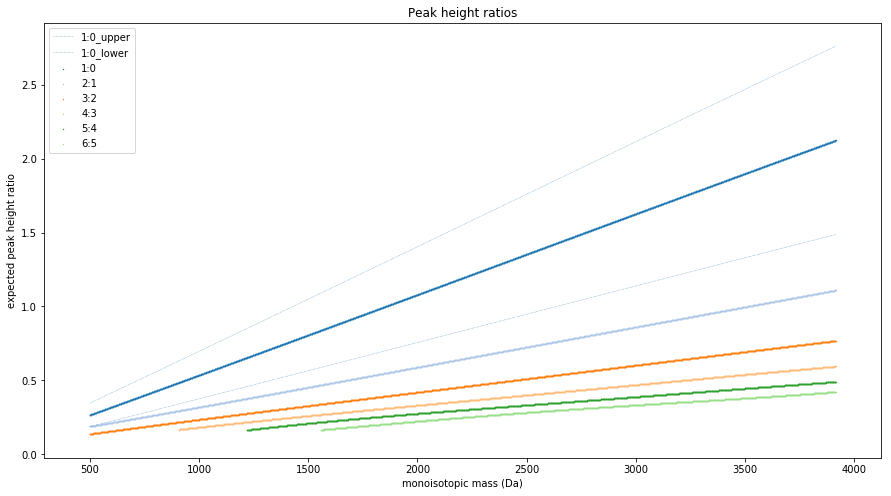

In [167]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peak height ratios')

ax.scatter(ratios_df.mass, ratios_df['1:0'], marker='o', color=tableau20_mpl[0], lw=0, s=2, alpha=1.0, label="1:0")
ax.scatter(ratios_df.mass, ratios_df['2:1'], marker='o', color=tableau20_mpl[1], lw=0, s=2, alpha=1.0, label="2:1")
ax.scatter(ratios_df.mass, ratios_df['3:2'], marker='o', color=tableau20_mpl[2], lw=0, s=2, alpha=1.0, label="3:2")
ax.scatter(ratios_df.mass, ratios_df['4:3'], marker='o', color=tableau20_mpl[3], lw=0, s=2, alpha=1.0, label="4:3")
ax.scatter(ratios_df.mass, ratios_df['5:4'], marker='o', color=tableau20_mpl[4], lw=0, s=2, alpha=1.0, label="5:4")
ax.scatter(ratios_df.mass, ratios_df['6:5'], marker='o', color=tableau20_mpl[5], lw=0, s=2, alpha=1.0, label="6:5")

ax.plot(ratios_df.mass, ratios_df['1:0_upper'], color=tableau20_mpl[0], lw=0.5, ls='dotted')
ax.plot(ratios_df.mass, ratios_df['1:0_lower'], color=tableau20_mpl[0], lw=0.5, ls='dotted')

plt.legend(loc='best')
plt.xlabel('monoisotopic mass (Da)')
plt.ylabel('expected peak height ratio')

plt.show()

In [168]:
# visualise peak height ratio by mass error
my_results_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/F359588.csv', sep=',', index_col=False, skiprows=61)

In [169]:
# discard low scoring features
my_results_df = my_results_df[my_results_df.pep_score >= 30]

In [170]:
my_results_df.iloc[0].pep_scan_title

'RawFile: HeLa_20KInt Charge: 2 FeatureIntensity: 276153 Feature#: 126 RtApex: 3030.12'

In [171]:
my_results_df['feature_id'] = my_results_df.pep_scan_title.str.split(" ").apply(lambda x: int(x[7]))

In [172]:
my_results_df.head()

,prot_hit_num,prot_family_member,prot_acc,prot_desc,prot_score,prot_mass,prot_matches,prot_matches_sig,prot_sequences,prot_sequences_sig,...,pep_score,pep_expect,pep_res_before,pep_seq,pep_res_after,pep_var_mod,pep_var_mod_pos,pep_summed_mod_pos,pep_scan_title,feature_id
3,1,1.0,2::SERA_HUMAN,D-3-phosphoglycerate dehydrogenase OS=Homo sap...,1124,57356,30,26,1,1,...,44.65,3.000000e-04,K,GTIQVITQGTSLK,N,NaN,NaN,NaN,RawFile: HeLa_20KInt Charge: 2 FeatureIntensit...,126
4,1,1.0,2::SERA_HUMAN,D-3-phosphoglycerate dehydrogenase OS=Homo sap...,1124,57356,30,26,1,1,...,79.52,1.900000e-07,K,GTIQVITQGTSLK,N,NaN,NaN,NaN,RawFile: HeLa_20KInt Charge: 2 FeatureIntensit...,126
5,1,1.0,2::SERA_HUMAN,D-3-phosphoglycerate dehydrogenase OS=Homo sap...,1124,57356,30,26,1,1,...,69.09,1.700000e-06,K,GTIQVITQGTSLK,N,NaN,NaN,NaN,RawFile: HeLa_20KInt Charge: 2 FeatureIntensit...,126
6,1,1.0,2::SERA_HUMAN,D-3-phosphoglycerate dehydrogenase OS=Homo sap...,1124,57356,30,26,1,1,...,79.86,2.600000e-07,K,GTIQVITQGTSLK,N,NaN,NaN,NaN,RawFile: HeLa_20KInt Charge: 2 FeatureIntensit...,126
7,1,1.0,2::SERA_HUMAN,D-3-phosphoglycerate dehydrogenase OS=Homo sap...,1124,57356,30,26,1,1,...,79.62,4.700000e-07,K,GTIQVITQGTSLK,N,NaN,NaN,NaN,RawFile: HeLa_20KInt Charge: 2 FeatureIntensit...,126


In [173]:
ms1_deduped_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/ms1_deduped_df.pkl')

In [174]:
ms1_deduped_df['peak_height_ratio'] = ms1_deduped_df.envelope.apply(lambda e: e[1][1] / e[0][1])

In [175]:
ms1_deduped_df['monoisotopic_mass'] = ms1_deduped_df.monoisotopic_mz * ms1_deduped_df.charge

In [176]:
ms1_deduped_df['expected_peak_height_ratio'] = ms1_deduped_df.monoisotopic_mass.apply(lambda x: peak_ratio(monoisotopic_mass=x, peak_number=1, number_of_sulphur=0))

In [177]:
ms1_deduped_df['phr_error'] = (ms1_deduped_df.peak_height_ratio - ms1_deduped_df.expected_peak_height_ratio) / ms1_deduped_df.expected_peak_height_ratio

In [178]:
my_results_df = pd.merge(my_results_df, ms1_deduped_df[['feature_id','phr_error']], how='left', left_on=['feature_id'], right_on=['feature_id'])

In [179]:
my_results_df.dropna(subset=['phr_error'], inplace=True)

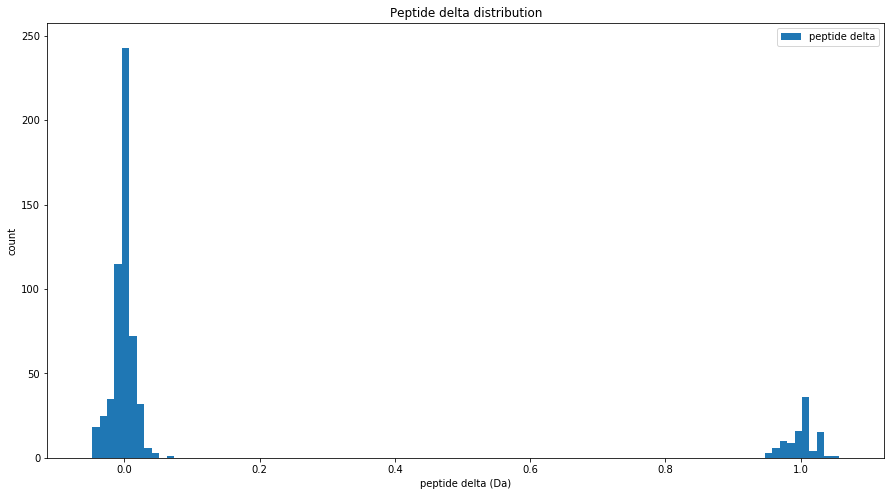

In [180]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide delta distribution')

bins = 100
hist, bins, _ = plt.hist(my_results_df.pep_delta, bins=bins, label='peptide delta')

plt.legend(loc='best')
plt.xlabel('peptide delta (Da)')
plt.ylabel('count')

plt.show()

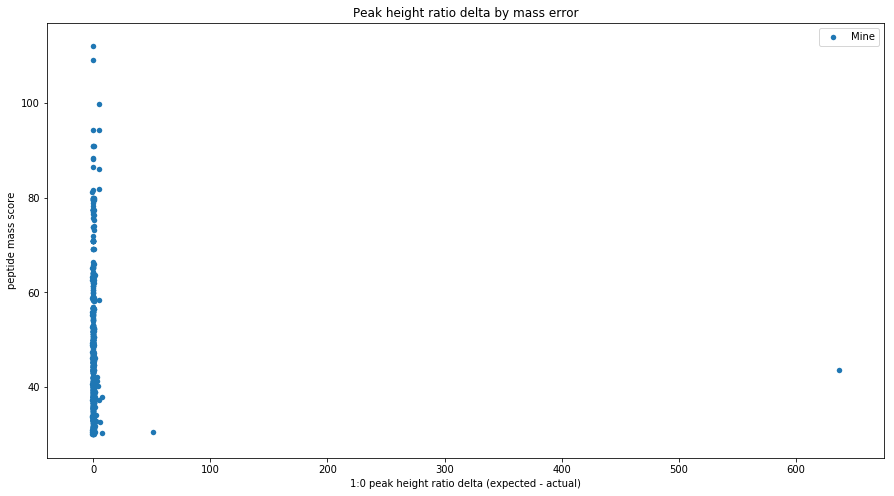

In [181]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peak height ratio delta by mass error')

ax.scatter(my_results_df.phr_error, my_results_df.pep_score, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=1.0, label="Mine")
plt.legend(loc='best')
plt.xlabel('1:0 peak height ratio delta (expected - actual)')
plt.ylabel('peptide mass score')

plt.show()

In [182]:
# filter out the features with huge PHR delta
my_results_df = my_results_df[(my_results_df.phr_error <= 1) & (my_results_df.phr_error >= -1)]

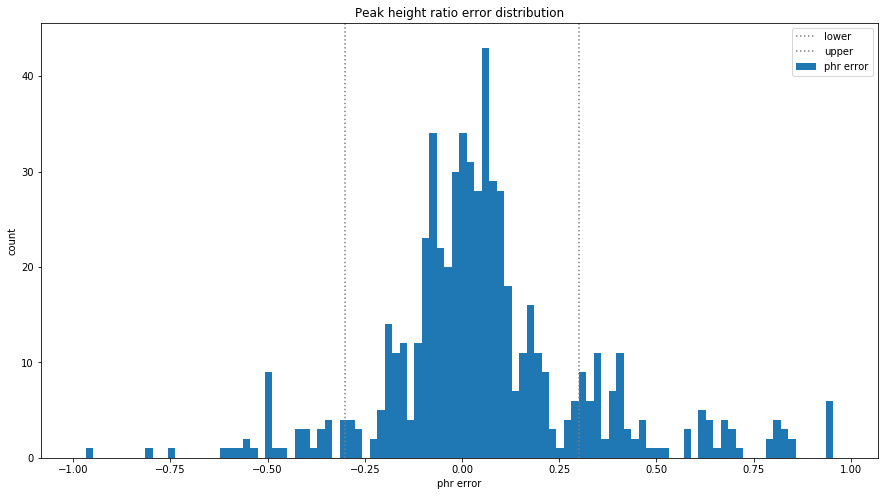

In [183]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peak height ratio error distribution')

bins = 100
hist, bins, _ = plt.hist(my_results_df.phr_error, bins=bins, label='phr error')

plt.axvline(x=-0.3, linestyle=':', color='gray', label='lower')
plt.axvline(x=+0.3, linestyle=':', color='gray', label='upper')

plt.legend(loc='best')
plt.xlabel('phr error')
plt.ylabel('count')

plt.show()

In [209]:
df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/checked_ms1_features.pkl')

In [210]:
df[df.mono_adjusted == True]

,candidate_phr_error,charge,envelope,intensity,mono_adjusted,monoisotopic_mz,ms2_frames,ms2_scan_ranges,original_phr,original_phr_error,precursor_id,rt_apex,rt_curve_fit,rt_lower,rt_upper,scan_apex,scan_curve_fit,scan_lower,scan_upper
25,-0.031286,2,"[(498.73668481800274, 103479.84521906395), (49...",179212.845219,True,498.741069,"[28155, 28160, 28161, 28185, 28268]","[(673, 698), (673, 698), (673, 698), (671, 696...",0.413200,-0.227077,92564,3025.97,True,3014.16,3037.77,693.92,False,630.00,705.00
28,-0.039157,3,"[(596.6108314311527, 10048.640260015958), (596...",26290.640260,True,596.615022,"[28078, 28079, 28132]","[(696, 721), (696, 721), (701, 726)]",0.497694,-0.484684,92565,3023.78,True,3013.78,3033.79,714.51,False,671.00,746.00
52,-0.015008,2,"[(684.8361918584153, 12070.127911192927), (685...",207334.127911,True,684.840684,"[28188, 28191, 28193]","[(505, 530), (505, 530), (505, 530)]",7.215232,8.794670,92580,3011.32,True,2989.07,3033.57,526.20,False,474.00,549.00
135,0.048617,3,"[(467.22514227279663, 2915.511489077094), (467...",10266.883396,True,467.221570,"[28095, 28096, 28097, 28110, 28112, 28114, 281...","[(788, 813), (788, 813), (791, 816), (796, 821...",2.153232,1.855495,92631,3024.07,False,3002.23,3032.23,797.97,True,740.27,855.68
140,0.047490,2,"[(746.3779619446993, 37945.643768368696), (746...",110537.643768,True,746.373539,"[28086, 28087, 28090, 28092, 28093, 28098, 280...","[(487, 512), (487, 512), (487, 512), (487, 512...",0.723360,-0.099929,92634,3018.62,True,2994.29,3042.96,493.31,True,467.48,519.15
175,-0.025400,2,"[(593.3283750455394, 84818.8977554187), (593.8...",176553.897755,True,593.324214,"[28103, 28104, 28231, 28232]","[(603, 628), (603, 628), (606, 631), (606, 631)]",0.741675,0.164043,92654,3019.41,True,3003.47,3035.35,618.05,True,597.91,638.19
181,0.023688,2,"[(444.72878875211256, 92905.68584004401), (445...",157956.685840,True,444.725323,"[28151, 28204, 28205, 28206]","[(726, 751), (731, 756), (731, 756), (731, 756)]",0.436521,-0.083188,92656,3019.08,False,3002.87,3032.87,733.05,False,680.00,755.00
268,0.043142,2,"[(586.2969015608795, 21093.570050556744), (586...",52673.617772,True,586.302269,[28230],"[(617, 642)]",1.279746,1.032847,92702,3016.51,False,3004.27,3034.27,639.28,True,593.65,684.91
274,-0.017393,2,"[(754.4087979729856, 126558.13636381575), (754...",303095.136364,True,754.405337,"[28117, 28118, 28122, 28123, 28127, 28218]","[(485, 510), (485, 510), (490, 515), (490, 515...",0.530832,-0.346603,92705,3017.80,True,2998.75,3036.84,496.45,True,480.02,512.89
296,0.035852,2,"[(523.7843782295405, 28782.178424528232), (524...",62545.077620,True,523.781404,"[28119, 28128, 28164, 28183, 28184, 28273, 282...","[(672, 697), (672, 697), (668, 693), (682, 707...",1.016009,0.808775,92716,3027.59,True,2981.09,3074.09,682.79,True,649.53,716.06


In [204]:
t = df[df.mono_adjusted == True].iloc[0]

In [205]:
t.envelope

[(498.73668481800274, 103479.84521906395),
 (499.2514, 53589.00),
 (499.7440, 22143.00),
 (500.2542, 1.00)]

In [206]:
t.monoisotopic_mz * t.charge

997.4821381210857

In [207]:
peak_ratio(monoisotopic_mass=997.4821381210857, peak_number=1, number_of_sulphur=0)

0.534041854258891

In [208]:
print("{} out of {} were adjusted".format(len(df[df.mono_adjusted == True]), len(df)))

75 out of 2132 were adjusted


In [254]:
df['monoisotopic_mass'] = df.monoisotopic_mz * df.charge

In [257]:
t = df[(df.original_phr >= 1) & (df.original_phr <= 2) & (df.monoisotopic_mass >= 1500)]

In [258]:
len(t)

253

In [274]:
index = 2

In [275]:
t.iloc[index].original_phr

1.2670730526767744

In [276]:
monoisotopic_mass = t.iloc[index].monoisotopic_mass
monoisotopic_mass

1897.8646243901742

In [280]:
df['phr_2'] = peak_ratio(monoisotopic_mass=df.monoisotopic_mass, peak_number=2, number_of_sulphur=0)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().